# stock data를 활용한 종가 예측

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 데이터 로드 및 종목 코드 기반 주식 데이터 로드

In [2]:
stock_list = pd.read_csv('dongkeun_ICT/stock_final/Stock_List.csv')

In [3]:
stock_list.head()

,종목명,종목코드,상장시장
0,삼성전자,5930,KOSPI
1,SK하이닉스,660,KOSPI
2,NAVER,35420,KOSPI
3,카카오,35720,KOSPI
4,삼성바이오로직스,207940,KOSPI


In [4]:
import FinanceDataReader as fdr # 가격 확인을 위하여 라이브러리 로드

In [5]:
#  종목코드 형태 균일화
stock_list['종목코드'] = stock_list['종목코드'].apply(lambda x :str(x).zfill(6)) # 파이썬 문자열에서 6개를 0으로 채우는 함수, 4자리 글자는 2개의 0이 추가된다.
stock_list.head()

,종목명,종목코드,상장시장
0,삼성전자,005930,KOSPI
1,SK하이닉스,000660,KOSPI
2,NAVER,035420,KOSPI
3,카카오,035720,KOSPI
4,삼성바이오로직스,207940,KOSPI


In [6]:
print(len(stock_list))

376


In [7]:
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   종목명     376 non-null    object
 1   종목코드    376 non-null    object
 2   상장시장    376 non-null    object
dtypes: object(3)
memory usage: 8.9+ KB


In [8]:
# 학습 대상 날짜 설정 및 기타 정보 파악
start_date = '20210104'
end_date = '20210903'

start_weekday = pd.to_datetime(start_date).weekday()
max_weeknum = pd.to_datetime(end_date).strftime("%V")
Business_days = pd.DataFrame(pd.date_range(start_date,end_date,freq="B"),columns = ['Date'])

print(f'WEEKDAY of "start_date": {start_weekday}')
print(f'NUM of WEEKS to "end_date" : {max_weeknum}')
print(f'HOW MANY "Business_days" : {Business_days.shape}', )
display(Business_days.head())

WEEKDAY of "start_date": 0
NUM of WEEKS to "end_date" : 35
HOW MANY "Business_days" : (175, 1)


,Date
0,2021-01-04
1,2021-01-05
2,2021-01-06
3,2021-01-07
4,2021-01-08


In [9]:
# 지정한 날짜에 해당하는 주식 데이터를 종목코드와 라이브러리를 사용하여 로드
test_code = stock_list.loc[0,'종목코드']
test = fdr.DataReader(test_code,start = start_date, end = end_date).reset_index()
test.tail()

,Date,Open,High,Low,Close,Volume,Change
164,2021-08-30,75400,75500,74200,74600,12686999,0.004038
165,2021-08-31,74900,76700,74300,76700,24630370,0.028150
166,2021-09-01,76700,77100,75900,76800,16114775,0.001304
167,2021-09-02,76800,76800,75700,76000,15347486,-0.010417
168,2021-09-03,76400,76700,76000,76600,12096419,0.007895


In [10]:
# 전체 학습 후 모델 성능 평가를 위하여
train_test = test[-5:]
train_test

,Date,Open,High,Low,Close,Volume,Change
164,2021-08-30,75400,75500,74200,74600,12686999,0.004038
165,2021-08-31,74900,76700,74300,76700,24630370,0.028150
166,2021-09-01,76700,77100,75900,76800,16114775,0.001304
167,2021-09-02,76800,76800,75700,76000,15347486,-0.010417
168,2021-09-03,76400,76700,76000,76600,12096419,0.007895


In [11]:
# 이동평균 값 추가
ma5 = test['Close'].rolling(window=5).mean()
test['MA5'] = ma5
test = test.fillna(0) #첫 네개의 값은 이동평균값이 없으므로 결측값으로 나오는데, 이를 0으로 채운다
test

,Date,Open,High,Low,Close,Volume,Change,MA5
0,2021-01-04,81000,84400,80200,83000,38655276,0.024691,0.0
1,2021-01-05,81600,83900,81600,83900,35335669,0.010843,0.0
2,2021-01-06,83300,84500,82100,82200,42089013,-0.020262,0.0
3,2021-01-07,82800,84200,82700,82900,32644642,0.008516,0.0
4,2021-01-08,83300,90000,83000,88800,59013307,0.071170,84160.0
...,...,...,...,...,...,...,...,...
164,2021-08-30,75400,75500,74200,74600,12686999,0.004038,74960.0
165,2021-08-31,74900,76700,74300,76700,24630370,0.028150,75180.0
166,2021-09-01,76700,77100,75900,76800,16114775,0.001304,75400.0
167,2021-09-02,76800,76800,75700,76000,15347486,-0.010417,75680.0


### 외부 데이터 수집

In [12]:
import pandas_datareader as pdr
nasdaq = pdr.get_data_yahoo('^IXIC', start_date, end_date).reset_index() # 나스닥 데이터 수집
nasdaq.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2021-01-04,12958.719727,12543.240234,12958.519531,12698.450195,6546740000,12698.450195
1,2021-01-05,12828.269531,12665.650391,12665.650391,12818.959961,6904420000,12818.959961
2,2021-01-06,12909.629883,12649.990234,12666.150391,12740.790039,7648340000,12740.790039
3,2021-01-07,13090.910156,12867.339844,12867.339844,13067.480469,6777010000,13067.480469
4,2021-01-08,13208.089844,13036.549805,13160.219727,13201.980469,7223660000,13201.980469


In [13]:
test['n_close'] = nasdaq['Adj Close']
test['n_high'] = nasdaq['High']

### data scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Open','High','Low','Close','Volume','Change','MA5','n_close','n_high']
sc = scaler.fit(test[scale_cols])
df_scaled = sc.transform(test[scale_cols])
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
scale_cols2 = ['Close']
sc2 = scaler2.fit(test[scale_cols2])
df_scaled_2 = sc2.transform(test[scale_cols2])
df_scaled_2 = pd.DataFrame(df_scaled_2)
df_scaled_2.columns = scale_cols2

In [16]:
df_scaled['Date']=test['Date']
df_scaled['Close'] = df_scaled_2['Close']

### 상관관계 분석

<AxesSubplot:>

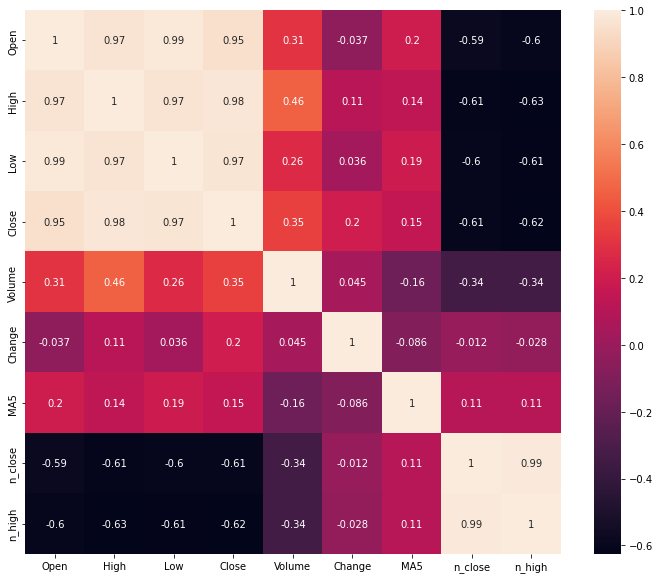

In [17]:
import seaborn as sns
plt.figure(figsize=(12,10))
sns.heatmap(df_scaled.corr(),annot=True)

In [18]:
print(len(test))

169


#### 데이터 시각화

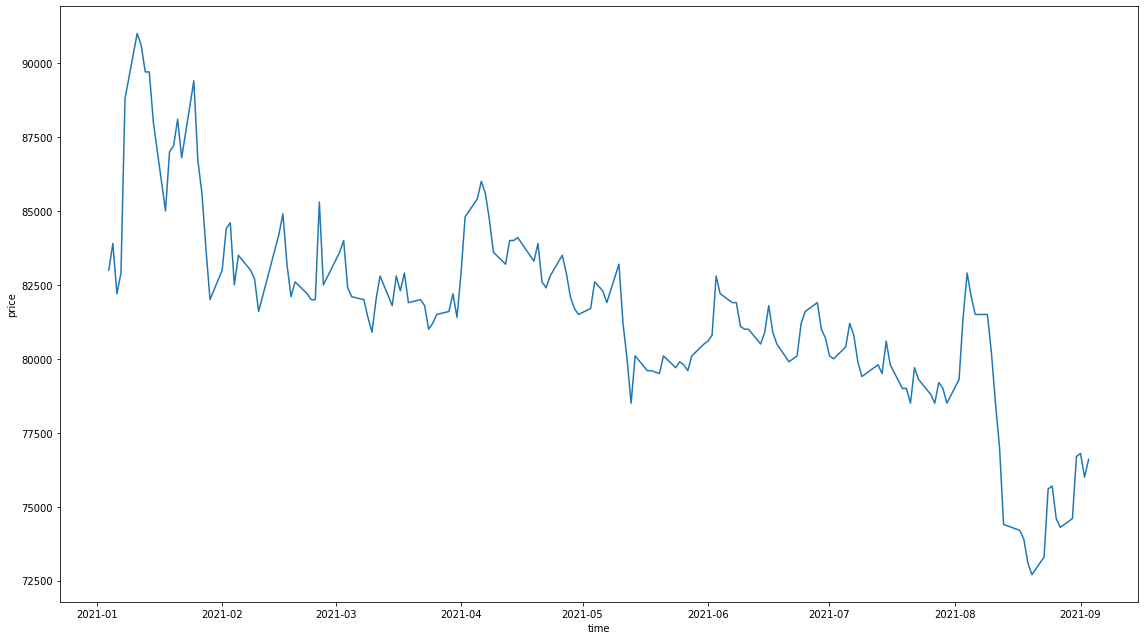

In [19]:
plt.figure(figsize = (16,9))
sns.lineplot(y=test.loc[:,'Close'], x=test.loc[:,'Date'])
plt.xlabel('time')
plt.ylabel('price')
plt.tight_layout()
plt.show()

### pivot table 생성

In [20]:
test2 = pd.merge(Business_days, df_scaled, how='outer')
test2['weekday'] = test2.Date.apply(lambda x : x.weekday())
test2['weeknum'] = test2.Date.apply(lambda x : x.strftime('%V'))
test2.Close = test2.Close.ffill()
# test2 = pd.pivot_table(data = test2, values = ['Close','High','Low','Open'], columns = 'weekday', index = 'weeknum')
# test2 = pd.pivot_table(data = test2, values = ['Close','High','MA5','Low','n_high','n_close'], columns = 'weekday', index = 'weeknum')
test2 = pd.pivot_table(data = test2, values = ['Close','High','MA5','Volume'], columns = 'weekday', index = 'weeknum')
test2.head()

Close                                              High            \
weekday         0         1         2         3         4         0         1   
weeknum                                                                         
01       0.562842  0.612022  0.519126  0.557377  0.879781  0.458515  0.436681   
02       1.000000  0.978142  0.928962  0.928962  0.836066  1.000000  0.764192   
03       0.672131  0.781421  0.792350  0.841530  0.770492  0.585153  0.615721   
04       0.912568  0.765027  0.704918  0.601093  0.508197  0.698690  0.668122   
05       0.562842  0.639344  0.650273  0.535519  0.590164  0.414847  0.545852   

                                            MA5                                \
weekday         2         3         4         0         1         2         3   
weeknum                                                                         
01       0.462882  0.449782  0.703057  0.000000  0.000000  0.000000  0.000000   
02       0.755459  0.703057  0.781659  0.953313  0.968208  0.984882  1.000000   
03       0.659389  0.641921  0.689956  0.984882  0.976879  0.971321  0.967763   
04       0.602620  0.510917  0.484716  0.974878  0.974211  0.970654  0.960871   
05       0.502183  0.432314  0.441048  0.935972  0.930858  0.928635  0.925967   

                     Volume                                          
weekday         4         0         1         2         3         4  
weeknum                                                              
01       0.935527  0.369920  0.329425  0.411808  0.296598  0.618264  
02       0.998221  1.000000  0.492240  0.338369  0.220347  0.306200  
03       0.965096  0.425702  0.385044  0.205918  0.207222  0.274848  
04       0.950200  0.230894  0.303116  0.220702  0.287024  0.381640  
05       0.929302  0.240510  0.219226  0.168115  0.193238  0.118400

In [21]:
# test3 = pd.merge(Business_days, test, how='outer')
# test3['weekday'] = test3.Date.apply(lambda x : x.weekday())
# test3['weeknum'] = test3.Date.apply(lambda x : x.strftime('%V'))
# test3.Close = test3.Close.ffill()
# test3 = pd.pivot_table(data = test3, values = ['Close','High','Low'], columns = 'weekday', index = 'weeknum')
# test3.head()

In [22]:
test2.isna().sum()

        weekday
Close   0          0
        1          0
        2          0
        3          0
        4          0
High    0          2
        1          0
        2          2
        3          1
        4          1
MA5     0          2
        1          0
        2          2
        3          1
        4          1
Volume  0          2
        1          0
        2          2
        3          1
        4          1
dtype: int64

In [23]:
test2[:].describe()

Close                                                   High  \
weekday          0          1          2          3          4          0   
count    35.000000  35.000000  35.000000  35.000000  35.000000  33.000000   
mean      0.486339   0.500546   0.480562   0.474005   0.468696   0.380839   
std       0.189476   0.174387   0.167238   0.177631   0.184645   0.171785   
min       0.032787   0.081967   0.065574   0.021858   0.000000   0.004367   
25%       0.387978   0.404372   0.393443   0.387978   0.401639   0.292576   
50%       0.502732   0.497268   0.475410   0.491803   0.486339   0.371179   
75%       0.568306   0.603825   0.549180   0.554645   0.546448   0.445415   
max       1.000000   0.978142   0.928962   0.928962   0.879781   1.000000   

                                                           MA5             \
weekday          1          2          3          4          0          1   
count    35.000000  33.000000  34.000000  34.000000  33.000000  35.000000   
mean      0.378915   0.370253   0.357180   0.358335   0.881247   0.881516   
std       0.150110   0.146743   0.139696   0.165747   0.161597   0.156869   
min       0.052402   0.030568   0.021834   0.000000   0.000000   0.000000   
25%       0.301310   0.292576   0.272926   0.280568   0.889062   0.887506   
50%       0.379913   0.375546   0.371179   0.358079   0.909071   0.910627   
75%       0.451965   0.441048   0.430131   0.418122   0.923077   0.924522   
max       0.764192   0.755459   0.703057   0.781659   0.984882   0.976879   

                                             Volume                        \
weekday          2          3          4          0          1          2   
count    33.000000  34.000000  34.000000  33.000000  35.000000  33.000000   
mean      0.879967   0.879384   0.905965   0.137027   0.145834   0.147196   
std       0.161666   0.159265   0.035000   0.181260   0.115231   0.094490   
min       0.000000   0.000000   0.818808   0.000000   0.018694   0.039581   
25%       0.891730   0.887116   0.889229   0.055923   0.055266   0.080242   
50%       0.908404   0.903957   0.905625   0.087331   0.111783   0.117056   
75%       0.926189   0.923799   0.922410   0.134842   0.203654   0.205918   
max       0.984882   1.000000   0.998221   1.000000   0.492240   0.411808   

                               
weekday          3          4  
count    34.000000  34.000000  
mean      0.156567   0.154993  
std       0.086924   0.152044  
min       0.052306   0.005149  
25%       0.098658   0.064322  
50%       0.126780   0.107313  
75%       0.194854   0.174451  
max       0.415177   0.645801

In [24]:
test2[:]['High'][0].fillna(test2[:]['High'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
test2[:]['High'][2].fillna(test2[:]['High'][2].median(),inplace=True)
test2[:]['High'][3].fillna(test2[:]['High'][3].median(),inplace=True)
test2[:]['High'][4].fillna(test2[:]['High'][4].median(),inplace=True)

test2[:]['Volume'][0].fillna(test2[:]['Volume'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
test2[:]['Volume'][2].fillna(test2[:]['Volume'][2].median(),inplace=True)
test2[:]['Volume'][3].fillna(test2[:]['Volume'][3].median(),inplace=True)
test2[:]['Volume'][4].fillna(test2[:]['Volume'][4].median(),inplace=True)

test2[:]['MA5'][0].fillna(test2[:]['MA5'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
test2[:]['MA5'][2].fillna(test2[:]['MA5'][2].median(),inplace=True)
test2[:]['MA5'][3].fillna(test2[:]['MA5'][3].median(),inplace=True)
test2[:]['MA5'][4].fillna(test2[:]['MA5'][4].median(),inplace=True)

# test2[:]['n_high'][0].fillna(test2[:]['n_high'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# test2[:]['n_high'][2].fillna(test2[:]['n_high'][2].median(),inplace=True)
# test2[:]['n_high'][3].fillna(test2[:]['n_high'][3].median(),inplace=True)
# test2[:]['n_high'][4].fillna(test2[:]['n_high'][4].median(),inplace=True)

# test2[:]['n_close'][0].fillna(test2[:]['n_close'][0].median(),inplace=True) # inplace=True로 결측치 치환 반영
# test2[:]['n_close'][2].fillna(test2[:]['n_close'][2].median(),inplace=True)
# test2[:]['n_close'][3].fillna(test2[:]['n_close'][3].median(),inplace=True)
# test2[:]['n_close'][4].fillna(test2[:]['n_close'][4].median(),inplace=True)

In [25]:
test2.isna().sum()

        weekday
Close   0          0
        1          0
        2          0
        3          0
        4          0
High    0          0
        1          0
        2          0
        3          0
        4          0
MA5     0          0
        1          0
        2          0
        3          0
        4          0
Volume  0          0
        1          0
        2          0
        3          0
        4          0
dtype: int64

In [26]:
# test2.isna()

### 모델 학습 테스트

In [27]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet,SGDRegressor
from tqdm import tqdm

In [28]:
model = SGDRegressor(penalty='elasticnet',tol=1e-5,random_state=42)
x = test2.iloc[0:-2].to_numpy() # 0 to -2까지의 데이터로 학습을 하여서

y = test2.iloc[1:-1]['Close'].to_numpy() # 1 to -1까지의 데이터르 예측하는 과정을 수행
# 우리의 예측 대상은 월,화,수,목,금 5개의 feature이다.
y_0 = y[:,0] # 월요일
y_1 = y[:,1] # 화요일
y_2 = y[:,2] # 수요일
y_3 = y[:,3] # 목요일
y_4 = y[:,4] # 금요일

y_values = [y_0, y_1, y_2, y_3, y_4]

print(x.shape)
print(y_0.shape)
##################################
x_public = test2.iloc[-2].to_numpy()

predicitions = []
for y_value in y_values:
    model.fit(x,y_value)
    prediction = model.predict(np.expand_dims(x_public,0)) # 차원 추가
    predicitions.append(prediction[0])
    
print('-'*10)
print(predicitions)

y_public = test2.iloc[-1]['Close'].values

from sklearn.metrics import mean_squared_log_error
print(mean_squared_log_error(predicitions, y_public))

#0.0016648133440614176

(33, 20)
(33,)
----------
[0.17305792834036793, 0.20314573230440247, 0.20541267405574504, 0.1916378974153353, 0.20315125297757902]
0.0008514508744918417


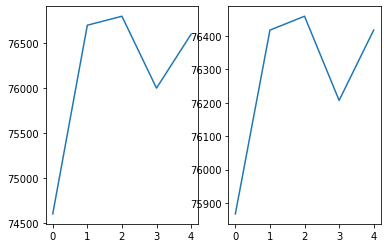

In [29]:
plt.subplot(1,2,1)
plt.plot(sc2.inverse_transform(y_public.reshape(-1,1)))
plt.subplot(1,2,2)
plt.plot(sc2.inverse_transform(np.array(predicitions).reshape(-1,1)))

## 전체 모델링

In [31]:
sample_name = 'dongkeun_ICT/stock_final/sample_submission_week3.csv'
sample_submission = pd.read_csv(sample_name)

In [32]:
model = SGDRegressor(penalty='elasticnet',tol=1e-5,random_state=42)
for code in tqdm(stock_list['종목코드'].values):

    # data load
    data = fdr.DataReader(code, start = start_date, end = end_date).reset_index()
    # 이동평균 값 추가
    ma5 = data['Close'].rolling(window=5).mean()
    data['MA5'] = ma5
    data = data.fillna(0) #첫 네개의 값은 이동평균값이 없으므로 결측값으로 나오는데, 이를 0으로 채운다

    # scaling
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scale_cols = ['Open','High','Low','Close','Volume','Change','MA5']
    sc = scaler.fit(data[scale_cols])
    df_scaled = sc.transform(data[scale_cols])
    df_scaled = pd.DataFrame(df_scaled)
    df_scaled.columns = scale_cols
    
    scaler2 = MinMaxScaler()
    scale_cols2 = ['Close']
    sc2 = scaler2.fit(data[scale_cols2])
    df_scaled_2 = sc2.transform(data[scale_cols2])
    df_scaled_2 = pd.DataFrame(df_scaled_2)
    df_scaled_2.columns = scale_cols2
    
    df_scaled['Date']=data['Date']
    df_scaled['Close'] = df_scaled_2['Close']
    
    # make pivot table
    data = pd.merge(Business_days, df_scaled, how = 'outer')
    data['weekday'] = data.Date.apply(lambda x : x.weekday())
    data['weeknum'] = data.Date.apply(lambda x : x.strftime('%V'))
    data.Close = data.Close.ffill()
    data = pd.pivot_table(data = data, values = ['Close','High','MA5','Volume'], columns = 'weekday', index = 'weeknum')
    
    # nan value check
    if data.isna().sum().sum()>0:
        for i in range(5):
            data[:]['High'][i].fillna(data[:]['High'][i].median(),inplace=True) # inplace=True로 결측치 치환 반영
            data[:]['Volume'][i].fillna(data[:]['Volume'][i].median(),inplace=True)
            data[:]['Close'][i].fillna(data[:]['Close'][i].median(),inplace=True)
            data[:]['MA5'][i].fillna(data[:]['MA5'][i].median(),inplace=True)
              
    x = data.iloc[0:-2].to_numpy() # 2021년 1월 04일 ~ 2021년 8월 13일까지의 데이터로
    y = data.iloc[1:-1]['Close'].to_numpy() # 2021년 1월 11일 ~ 2021년 8월 20일까지의 데이터를 학습한다.
    y_0 = y[:,0]
    y_1 = y[:,1]
    y_2 = y[:,2]
    y_3 = y[:,3]
    y_4 = y[:,4]

    y_values = [y_0, y_1, y_2, y_3, y_4]
    x_public = data.iloc[-2].to_numpy() # 2021년 8월 23일부터 8월 27일까지의 데이터를 예측할 것이다.
    
    predictions = []
    for y_value in y_values :
        model.fit(x,y_value)
        prediction = model.predict(np.expand_dims(x_public,0))
        prediction = sc2.inverse_transform(prediction.reshape(-1,1))
        predictions.append(prediction[0])
#     print(predictions)
#     print(type(predictions[0]))

    sample_submission.loc[:,code] = predictions * 2
sample_submission.isna().sum().sum()

100%|██████████| 376/376 [01:07<00:00,  5.54it/s]


0

In [33]:
sample_submission.columns

Index(['Day', '000060', '000080', '000100', '000120', '000150', '000240',
       '000250', '000270', '000660',
       ...
       '330860', '336260', '336370', '347860', '348150', '348210', '352820',
       '357780', '363280', '950130'],
      dtype='object', length=377)

In [34]:
columns = list(sample_submission.columns[1:])

In [35]:
columns = ['Day'] + [str(x).zfill(6) for x in columns]

In [36]:
sample_submission.columns = columns

In [37]:
sample_submission.to_csv('BASELINE_Linear_Week3.csv',index=False)

In [38]:
sample_submission

,Day,000060,000080,000100,000120,000150,000240,000250,000270,000660,...,330860,336260,336370,347860,348150,348210,352820,357780,363280,950130
0,2021-08-30,24139.387998,32771.425733,61732.692500,168568.348690,88825.030851,17447.799160,58496.428136,82657.429985,106913.095904,...,46128.956121,48632.070114,60267.632146,33924.580158,30806.954962,54867.207153,282550.790608,287309.827597,29606.478413,18409.675974
1,2021-08-31,24422.694293,32708.753368,61719.943580,169002.437490,89111.172680,17729.921037,58168.822031,82954.430498,108240.354171,...,45842.383937,48297.795507,58742.128863,33949.086158,31218.378923,55290.644832,281821.248823,288898.906427,29752.445325,18431.829691
2,2021-09-01,24710.209786,32670.203119,61563.565616,170634.622071,89878.579034,17882.378278,57913.870329,82930.449575,107387.967433,...,45862.453878,48594.757317,59070.782476,34171.386508,31296.511724,56129.334766,279787.199006,288600.317487,29645.412060,18718.350141
3,2021-09-02,24862.048814,32613.103935,61199.010648,171556.998645,89205.220552,17871.842505,57419.046918,82875.862037,106510.617941,...,45647.081979,48377.748958,59483.473154,33784.657796,31200.230605,56274.473173,282424.771132,289081.336847,29461.751547,18822.076228
4,2021-09-03,24680.299412,32716.848661,61342.360042,170494.379736,88743.167526,17867.522110,57016.027843,82878.303439,106735.412490,...,45777.047235,48293.815783,59403.449410,33490.663822,31558.825897,55323.628026,282254.154943,291161.732298,29434.066988,18943.926098
5,2021-09-13,24139.387998,32771.425733,61732.692500,168568.348690,88825.030851,17447.799160,58496.428136,82657.429985,106913.095904,...,46128.956121,48632.070114,60267.632146,33924.580158,30806.954962,54867.207153,282550.790608,287309.827597,29606.478413,18409.675974
6,2021-09-14,24422.694293,32708.753368,61719.943580,169002.437490,89111.172680,17729.921037,58168.822031,82954.430498,108240.354171,...,45842.383937,48297.795507,58742.128863,33949.086158,31218.378923,55290.644832,281821.248823,288898.906427,29752.445325,18431.829691
7,2021-09-15,24710.209786,32670.203119,61563.565616,170634.622071,89878.579034,17882.378278,57913.870329,82930.449575,107387.967433,...,45862.453878,48594.757317,59070.782476,34171.386508,31296.511724,56129.334766,279787.199006,288600.317487,29645.412060,18718.350141
8,2021-09-16,24862.048814,32613.103935,61199.010648,171556.998645,89205.220552,17871.842505,57419.046918,82875.862037,106510.617941,...,45647.081979,48377.748958,59483.473154,33784.657796,31200.230605,56274.473173,282424.771132,289081.336847,29461.751547,18822.076228
9,2021-09-17,24680.299412,32716.848661,61342.360042,170494.379736,88743.167526,17867.522110,57016.027843,82878.303439,106735.412490,...,45777.047235,48293.815783,59403.449410,33490.663822,31558.825897,55323.628026,282254.154943,291161.732298,29434.066988,18943.926098


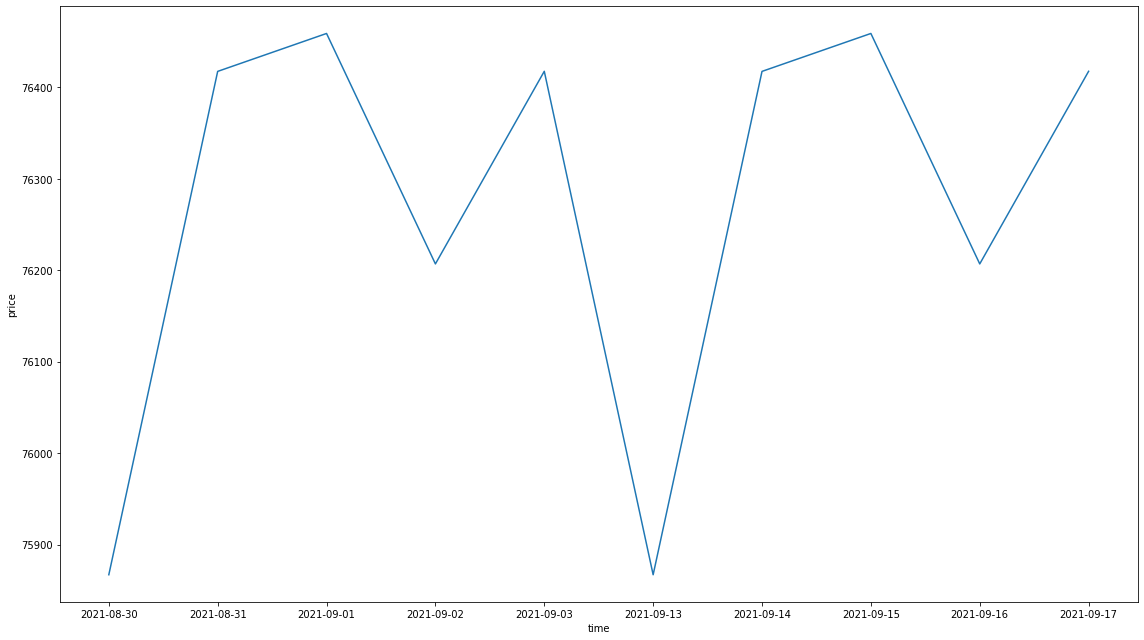

In [39]:
plt.figure(figsize = (16,9))
sns.lineplot(y=sample_submission.loc[:,'005930'], x=sample_submission.loc[:,'Day'])
plt.xlabel('time')
plt.ylabel('price')
plt.tight_layout()
plt.show()

In [40]:
np.sqrt(mean_squared_log_error(np.array(train_test['Close']), np.array(sample_submission.loc[:,'005930'][:5])))


### CLOSE, HIGH, MA5 == 0.00835658572700901
### CLOSE, HIGH == 0.011811242190284555
### CLOSE, HIGH, MA5, LOW == 0.013610053290184233
### 'Close','High','MA5','Volume' == 0.008125079770508761

0.008125079770508761